# MSA 2024 Phase 2 - Part 2

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


## 1. Load and split preprocessed data

In [58]:
#the data is scaled already
monthly_red_cols= pd.read_csv("monthly_red_cols.csv", encoding='latin1',delimiter=',',header='infer')
monthly_red_cols['Order Date'] = pd.to_datetime(monthly_red_cols['Order Date'])

# Set 'Order Date' as the index
monthly_red_cols.set_index('Order Date', inplace=True)

# Convert index to PeriodIndex with monthly frequency
#monthly_red_cols.index = pd.PeriodIndex(monthly_red_cols.index, freq='M')

In [56]:
monthly_red_cols.index.freq

## 2. Choose an algorithm

In [15]:

#checking for autocorrelation to help identify the repeating patterns in the data and help us select the right terms when fitting our time series model
autocorrelation_lag1 = monthly_red_cols['Sales'].autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = monthly_red_cols['Sales'].autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = monthly_red_cols['Sales'].autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag12 = monthly_red_cols['Sales'].autocorr(lag=12)
print("Twelve Month Lag: ", autocorrelation_lag12)


One Month Lag:  0.31134446634062024
Three Month Lag:  0.14771399488747913
Six Month Lag:  0.04762804104570501
Twelve Month Lag:  0.8842178561819388


## 3. Train and test a model

In [59]:
monthly_red_cols.head()


,Discount,Sales,Profit,Sub-Category_Bookcases,Sub-Category_Tables,Region_Central,Region_South,State_Alabama,State_Arizona,State_Arkansas,...,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Ship Mode_First Class,Ship Mode_Same Day,Ship Mode_Second Class,Segment_Home Office,Year
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-31,0.201923,6242.525,805.4665,5,1,4,8,0,1,2,...,3,0,0,0,0,5,0,3,3,2014
2014-02-28,0.160000,1839.658,120.6917,0,1,4,1,0,0,0,...,1,0,0,0,0,1,1,2,1,2014
2014-03-31,0.203088,14573.956,-1128.6550,3,8,7,9,0,1,0,...,1,4,0,0,0,4,1,4,8,2014
2014-04-30,0.113095,7944.837,554.3801,1,7,4,5,2,0,0,...,1,1,0,0,0,2,1,4,9,2014
2014-05-31,0.269792,6912.787,-349.8776,2,4,9,1,0,0,0,...,0,1,0,1,0,3,2,5,0,2014


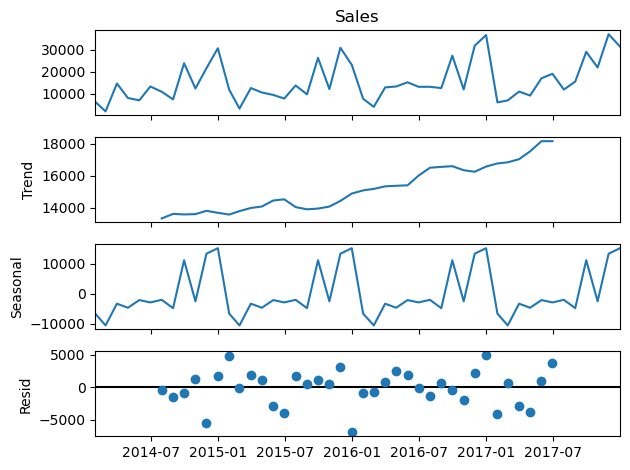

In [60]:
#Dcomposing the data to separate the trend and seasonal components to make it easier to visualize

result = seasonal_decompose(monthly_red_cols['Sales'], model='additive')
# Plot decomposition
result.plot()
plt.show()

From the decomposition plot we can see that here is a strong trend and seasonal pattern. However when we look at the residuals we can see there are some unusual values around December to February each year. For example around February 2015 seems to be a high residual. This could be due to the holiday shopping season or business cycles in retail. From the residuals of this model we can see there's still a pattern remainig, we will aim to capture this pattern by including terms in addition to the seasonal and first order differencing.

In [61]:
#Extract residuals from the decomposition plots to see if there are any unusual values we can visibly see 
residuals = result.resid
# Identify outliers in the residuals that are outside 2 standard deviations 
threshold = 2
outliers = residuals[abs(residuals) > threshold * residuals.std()]
print(outliers)

Order Date
2014-11-30   -5555.340745
2015-12-31   -6956.369442
Name: resid, dtype: float64


In [62]:
#checking the stationarity on the residuals to see if trend and seasonal differencing resulted in stationary data

adf_test = adfuller(residuals.dropna())
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -7.603198966899015
p-value: 2.3593438227156728e-11


The residuals are stationary (p-value ≤ 0.05) after applying differencing. This suggests that when fitting our model we would need to apply differencing to ensure that our data meets the time series model assumption that the data must be stationary 

## Plotting each differenced data to visualize the patterns

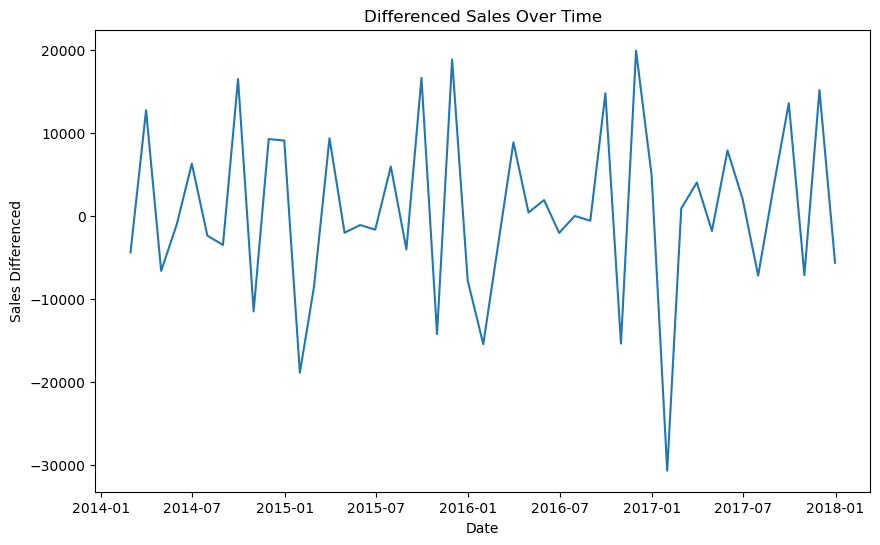

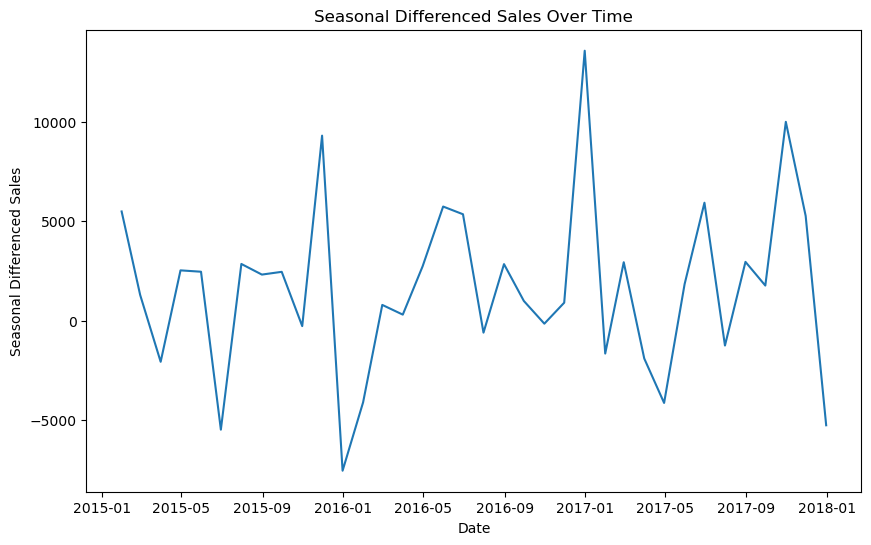

In [63]:
# First-order differencing
data_diff = monthly_red_cols['Sales'].diff().dropna()

# Seasonal differencing
data_seasonal_diff = monthly_red_cols['Sales'].diff(12).dropna()

# Plot differenced data
plt.figure(figsize=(10, 6))
plt.plot(monthly_red_cols.index[1:], data_diff)
plt.xlabel('Date')
plt.ylabel('Sales Differenced')
plt.title('Differenced Sales Over Time')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(monthly_red_cols.index[12:], data_seasonal_diff)
plt.xlabel('Date')
plt.ylabel('Seasonal Differenced Sales')
plt.title('Seasonal Differenced Sales Over Time')
plt.show()

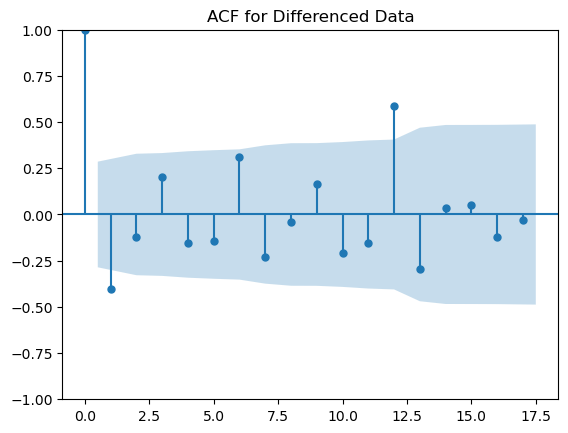

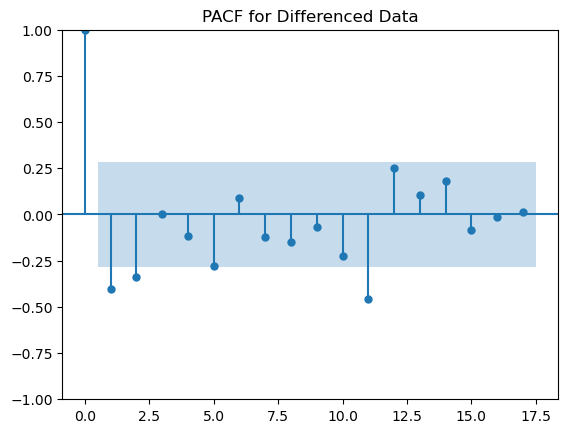

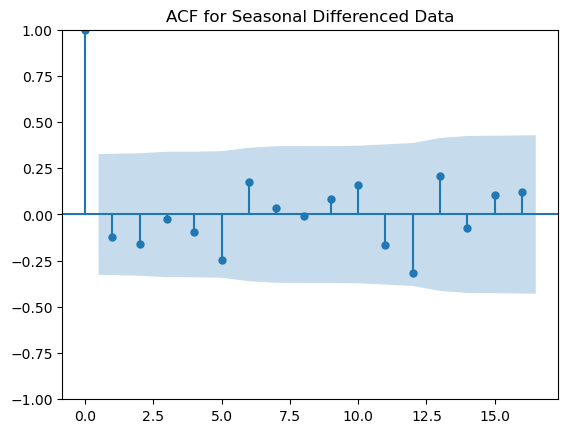

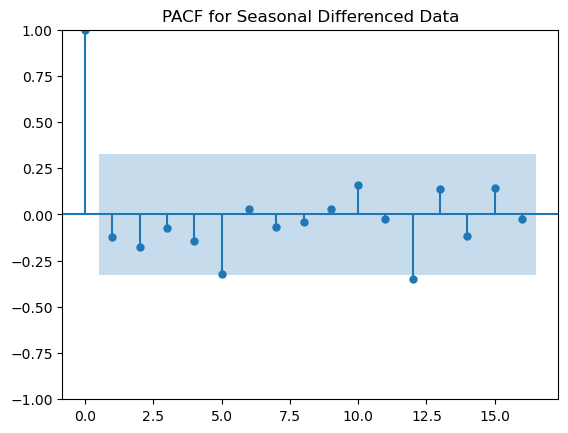

In [64]:

# ACF and PACF plots for differenced data
plot_acf(data_diff)
plt.title('ACF for Differenced Data')
plt.show()

plot_pacf(data_diff)
plt.title('PACF for Differenced Data')
plt.show()

# ACF and PACF plots for seasonal differenced data
plot_acf(data_seasonal_diff)
plt.title('ACF for Seasonal Differenced Data')
plt.show()

plot_pacf(data_seasonal_diff)
plt.title('PACF for Seasonal Differenced Data')
plt.show()

In [76]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the scaler
# scaler = StandardScaler()

# # Fit and transform the data (excluding the index)
# scaled_data = scaler.fit_transform(monthly_red_cols)

# # Create a DataFrame with the scaled data
# scaled_monthly_red_cols = pd.DataFrame(scaled_data, index=monthly_red_cols.index, columns=monthly_red_cols.columns)

# # Verify the standardized DataFrame
# print(scaled_monthly_red_cols.head())

            Discount     Sales    Profit  Sub-Category_Bookcases  \
Order Date                                                         
2014-01-31  0.749564 -1.023015  0.393735                0.081022   
2014-02-28 -0.432650 -1.511763 -0.246593               -1.539416   
2014-03-31  0.782421 -0.098171 -1.414849               -0.567153   
2014-04-30 -1.755346 -0.834047  0.158946               -1.215329   
2014-05-31  2.663430 -0.948612 -0.686620               -0.891241   

            Sub-Category_Tables  Region_Central  Region_South  State_Alabama  \
Order Date                                                                     
2014-01-31            -1.320852       -1.114452      0.265417      -0.391115   
2014-02-28            -1.320852       -1.114452     -1.449583      -0.391115   
2014-03-31             0.316809       -0.559154      0.510417      -0.391115   
2014-04-30             0.082858       -1.114452     -0.469583       3.022252   
2014-05-31            -0.618997       -0.18

After scaling the data it was noted that the p-values became non significant eventhough the lag terms were supposed to be as confirmed on the PACF and ACF plot. Therefore i have decided to use the original unscaled dataset.

C:\Users\filmo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
C:\Users\filmo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -22.836
Date:                            Mon, 15 Jul 2024   AIC                             57.671
Time:                                    21:26:32   BIC                             67.003
Sample:                                01-31-2014   HQIC                            60.893
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1273      0.255     -0.499      0.618      -0.627       0.373
ar.L2         -0.1725      0.282   

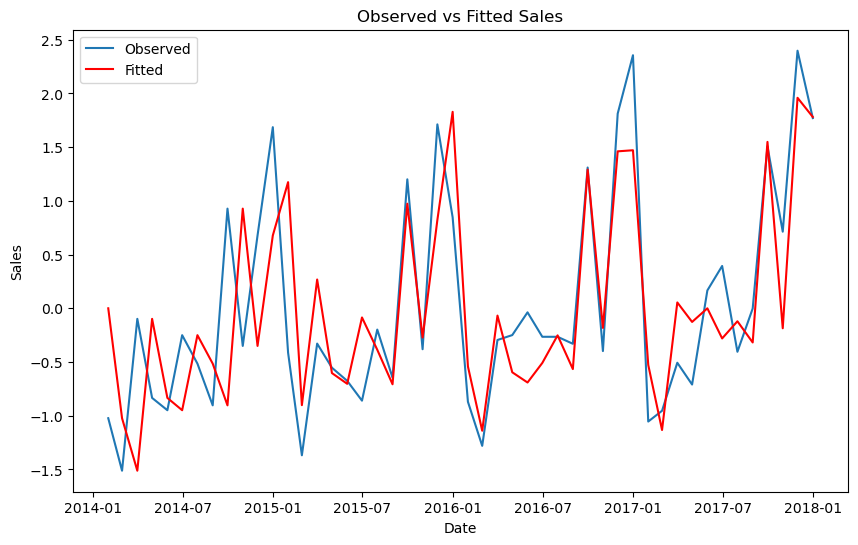

In [87]:

# Set random seed for reproducibility
np.random.seed(42)

# Fit SARIMA model
model = SARIMAX(scaled_monthly_red_cols['Sales'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 12), freq='M')

model_results = model.fit()

# Print model summary
print(model_results.summary())

# Plot the fitted values
plt.figure(figsize=(10, 6))
plt.plot(scaled_monthly_red_cols['Sales'], label='Observed')
plt.plot(model_results.fittedvalues, label='Fitted', color='red')
plt.title('Observed vs Fitted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 4. Evaluate the model 

In [ ]:
#

## 5. Summary